# Import Library

In [74]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM , Dense , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping

# Load the TESS Dataset

In [75]:
data_dir = "dataverse_files"

# Extract Features from Audio Files

In [76]:
def Extract_Feature(file_path):
    audio_data , sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio_data , sr=sr)
    return mfccs

# Prepare Data and Labels

In [77]:
features = []
labels = []
max_pad_len = 100

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            emotion = file.split('_')[2]
            emotion = emotion.split('.')[0]
            
            # Extract features and pad/truncate to a fixed length
            mfccs = Extract_Feature(file_path)
            
            # Pad or truncate the array to ensure fixed length
            if mfccs.shape[1] < max_pad_len:
                padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
            else:
                padded_mfccs = mfccs[:, :max_pad_len]
            features.append(padded_mfccs)
            labels.append(emotion)

In [78]:
X = features
y = labels

# converting lists to NumPy arrays enhances performance, facilitates integration with other libraries, and provides access to advanced array manipulation capabilities, making it a common practice in data analysis and machine learning workflows.

In [79]:
X = np.array(X)

# Encode the categorical labels into integers

In [80]:
Label_encoder = LabelEncoder()
y = Label_encoder.fit_transform(y)

# Convert the encoded categorical labels into one-hot encoded format

In [82]:
from keras.utils import to_categorical

y_one_hot = to_categorical(y)

# Split data into train and test sets

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define and Train LSTM Model

In [84]:
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_one_hot.shape[1], activation='softmax')
])

In [85]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 7)                 455       
                                                                 
Total params: 125959 (492.03 KB)
Trainable params: 125959 (492.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compile Model

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
70/70 [==============================] - 4s 27ms/step - loss: 1.5467 - accuracy: 0.4397 - val_loss: 0.9789 - val_accuracy: 0.7286
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.8385 - accuracy: 0.7491 - val_loss: 0.5151 - val_accuracy: 0.8268
Epoch 3/50
70/70 [==============================] - 1s 20ms/step - loss: 0.5375 - accuracy: 0.8335 - val_loss: 0.3815 - val_accuracy: 0.8589
Epoch 4/50
70/70 [==============================] - 1s 20ms/step - loss: 0.3700 - accuracy: 0.8786 - val_loss: 0.3382 - val_accuracy: 0.8750
Epoch 5/50
70/70 [==============================] - 1s 19ms/step - loss: 0.2983 - accuracy: 0.9054 - val_loss: 0.2802 - val_accuracy: 0.8946
Epoch 6/50
70/70 [==============================] - 1s 19ms/step - loss: 0.2252 - accuracy: 0.9304 - val_loss: 0.2454 - val_accuracy: 0.9161
Epoch 7/50
70/70 [==============================] - 1s 19ms/step - loss: 0.1985 - accuracy: 0.9339 - val_loss: 0.1955 - val_accuracy: 0.9357
Epoch 8/50
70

# PLOTING

In [88]:
import matplotlib.pyplot as plt

In [89]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_accuracy']

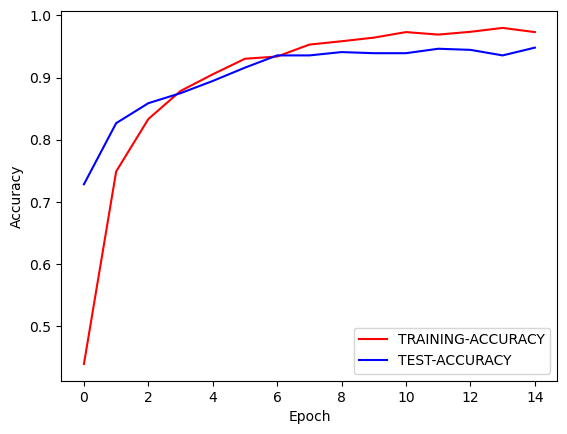

In [90]:
plt.plot(accuracy , color='red' , label='TRAINING-ACCURACY')
plt.plot(val_accuracy , color='blue' , label='TEST-ACCURACY')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

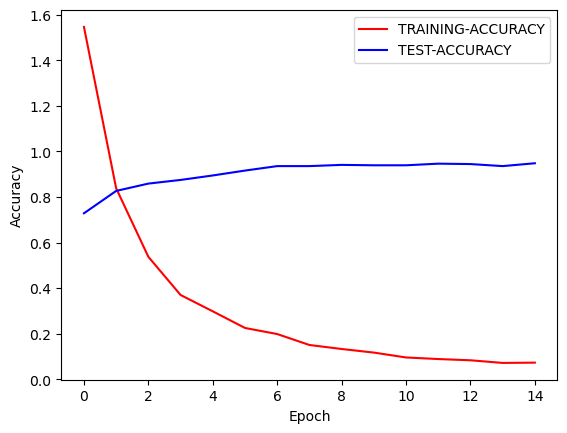

In [91]:
plt.plot(loss , color='red' , label='TRAINING-ACCURACY')
plt.plot(val_loss , color='blue' , label='TEST-ACCURACY')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
# Make predictions
predictions = model.predict(X_test)

# Convert predicted probabilities to labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to original labels
actual_labels = np.argmax(y_test, axis=1)

# Compare predicted labels with actual labels
correct_predictions = (predicted_labels == actual_labels)

# Calculate accuracy
accuracy = np.mean(correct_predictions)
print("Accuracy:", accuracy)

18/18 [==============================] - 0s 6ms/step
Accuracy: 0.9464285714285714


# MODEL ERROR

In [93]:
Error_rate = abs(y_test - predictions) * 100
print('MODEL-ERROR-RATE :',Error_rate.mean())

MODEL-ERROR-RATE : 2.1474524


In [101]:
def extract_feature(file_path):
    audio_data, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr)
    return mfccs

def preprocess_data(features, max_pad_len=100):
    padded_features = []
    for mfccs in features:
        if mfccs.shape[1] < max_pad_len:
            padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
        else:
            padded_mfccs = mfccs[:, :max_pad_len]
        padded_features.append(padded_mfccs)
    return np.array(padded_features)

In [170]:
def predict_emotion(audio_file_path, model, Label_encoder, max_pad_len=100):
    # Extract features from the audio file
    mfccs = extract_feature(audio_file_path)
    
    # Preprocess the features
    padded_mfccs = preprocess_data([mfccs], max_pad_len)
    
    # Make predictions using the model
    predictions = model.predict(padded_mfccs)
    
    # Convert the predicted labels to emotions
    predicted_label = np.argmax(predictions)
    predicted_emotion = Label_encoder.inverse_transform([predicted_label])[0]
    
    return predicted_emotion

# Usage:
audio_file_path = "Y2meta.app - Sad music meme (cut) (128 kbps).wav"
predicted_emotion = predict_emotion(audio_file_path, model, Label_encoder)
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 80ms/step
Predicted Emotion: angry


In [174]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
#model = load_model('emotion_model.h5')  # Replace 'emotion_model.h5' with the filename of your trained model

# Function to extract features from audio file
def extract_feature(file_path):
    audio_data, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr)
    return mfccs

# Function to preprocess features
def preprocess_features(features, max_pad_len=100):
    # Pad or truncate the array to ensure fixed length
    if features.shape[1] < max_pad_len:
        padded_features = np.pad(features, ((0, 0), (0, max_pad_len - features.shape[1])), mode='constant')
    else:
        padded_features = features[:, :max_pad_len]
    return padded_features

# Function to predict emotion
def predict_emotion(file_path):
    # Define emotion labels
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
    
    # Extract features
    features = extract_feature(file_path)
    # Preprocess features
    padded_features = preprocess_features(features)
    # Reshape features to match model input shape
    reshaped_features = np.expand_dims(padded_features, axis=0)  # Add batch dimension
    # Perform prediction
    predicted_emotion = model.predict(reshaped_features)
    # Get the index of the maximum probability
    predicted_class_index = np.argmax(predicted_emotion, axis=1)[0]
    # Get the corresponding emotion label
    predicted_emotion_label = emotion_labels[predicted_class_index]
    return predicted_emotion_label

In [195]:
file_path = "dataverse_files/OAF_bean_disgust.wav"
predict_emotion(file_path)

1/1 [==============================] - 0s 47ms/step


'disgust'

In [197]:
model.save('lstm_model.keras')

In [200]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('lstm_model.keras')  # Replace 'emotion_model.h5' with the filename of your trained model

# Function to extract features from audio file
def extract_feature(file_path):
    audio_data, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr)
    return mfccs

# Function to preprocess features
def preprocess_features(features, max_pad_len=100):
    # Pad or truncate the array to ensure fixed length
    if features.shape[1] < max_pad_len:
        padded_features = np.pad(features, ((0, 0), (0, max_pad_len - features.shape[1])), mode='constant')
    else:
        padded_features = features[:, :max_pad_len]
    return padded_features

# Function to predict emotion
def predict_emotion(file_path):
    # Define emotion labels
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
    
    # Extract features
    features = extract_feature(file_path)
    # Preprocess features
    padded_features = preprocess_features(features)
    # Reshape features to match model input shape
    reshaped_features = np.expand_dims(padded_features, axis=0)  # Add batch dimension
    # Perform prediction
    predicted_emotion = model.predict(reshaped_features)
    # Get the index of the maximum probability
    predicted_class_index = np.argmax(predicted_emotion, axis=1)[0]
    # Get the corresponding emotion label
    predicted_emotion_label = emotion_labels[predicted_class_index]
    return predicted_emotion_label

file_path = "dataverse_files/OAF_base_disgust.wav"
predict_emotion(file_path)

1/1 [==============================] - 0s 495ms/step


'disgust'